In [274]:
import torch.distributed as dist
import torch.utils.data
from torch import nn, optim
import csv
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.nn import functional as F
import numpy as np
import os
import pandas as pd

Q = 3
M = 5
WINDOW_SIZE = 64

In [342]:

def load_kpi(csv_path):
    kpis = {}
    anomalies = 0
    with open(csv_path) as f:
        input = csv.reader(f, delimiter=',')
        cnt = 0
        for row in input:
            if cnt == 0:
                cnt += 1
                continue
            kpi = kpis.get(str(row[3]), [[], [], []])
            kpi[0].append(int(row[0]))  # timestamp
            kpi[1].append(float(row[1]))  # value
            kpi[2].append(int(row[2]))  # label
            kpis[str(row[3])] = kpi
            cnt += 1
            if int(row[2]) == 1:
                anomalies += 1
        print("Training data loaded. Total length: {}, number of anomalies: {}".format(cnt, anomalies))
        f.close()
    return kpis


class SRCNN(nn.Module):
    def __init__(self, window=WINDOW_SIZE):
        self.window = window
        super(SRCNN, self).__init__()
        self.layer1 = nn.Conv1d(window, window, kernel_size=1, stride=1, padding=0)
        self.layer2 = nn.Conv1d(window, 2 * window, kernel_size=1, stride=1, padding=0)
        self.fc1 = nn.Linear(2 * window, 4 * window)
        self.fc2 = nn.Linear(4 * window, window)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = x.view(x.size(0), self.window, 1)
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return torch.sigmoid(x)

def spectral_residual(values):
    """
    This method transform a time series into spectral residual series
    :param values: list.
        a list of float values.
    :return: mag: list.
        a list of float values as the spectral residual values
    """
    EPS = 1e-8
    trans = np.fft.fft(values)
    mag = np.sqrt(trans.real ** 2 + trans.imag ** 2)

    maglog = [np.log(item) if abs(item) > EPS else 0 for item in mag]

    spectral = np.exp(maglog - average_filter(maglog, n=Q))

    trans.real = [ireal * ispectral / imag if abs(imag) > EPS else 0
                  for ireal, ispectral, imag in zip(trans.real, spectral, mag)]
    trans.imag = [iimag * ispectral / imag if abs(imag) > EPS else 0
                  for iimag, ispectral, imag in zip(trans.imag, spectral, mag)]

    wave_r = np.fft.ifft(trans)
    mag = np.sqrt(wave_r.real ** 2 + wave_r.imag ** 2)

    return mag


def average_filter(values, n=3):
    """
    Calculate the sliding window average for the give time series.
    Mathematically, res[i] = sum_{j=i-t+1}^{i} values[j] / t, where t = min(n, i+1)
    :param values: list.
        a list of float numbers
    :param n: int, default 3.
        window size.
    :return res: list.
        a list of value after the average_filter process.
    """

    if n >= len(values):
        n = len(values)

    res = np.cumsum(values, dtype=float)
    res[n:] = res[n:] - res[:-n]
    res[n:] = res[n:] / n

    for i in range(1, n):
        res[i] /= (i + 1)

    return res


def predict_next(values):
    """
    Predicts the next value by sum up the slope of the last value with previous values.
    Mathematically, g = 1/m * sum_{i=1}^{m} g(x_n, x_{n-i}), x_{n+1} = x_{n-m+1} + g * m,
    where g(x_i,x_j) = (x_i - x_j) / (i - j)
    :param values: list.
        a list of float numbers.
    :return : float.
        the predicted next value.
    """

    if len(values) <= 1:
        raise ValueError(f'data should contain at least 2 numbers')

    v_last = values[-1]
    n = len(values)

    slopes = [(v_last - v) / (n - 1 - i) for i, v in enumerate(values[:-1])]

    return values[1] + sum(slopes)


def extend_series(values, extend_num=M, look_ahead=M):
    """
    extend the array data by the predicted next value
    :param values: list.
        a list of float numbers.
    :param extend_num: int, default 5.
        number of values added to the back of data.
    :param look_ahead: int, default 5.
        number of previous values used in prediction.
    :return: list.
        The result array.
    """

    if look_ahead < 1:
        raise ValueError('look_ahead must be at least 1')

    extension = [predict_next(values[-look_ahead - 2:-1])] * extend_num
    return np.concatenate((values, extension), axis=0)

def normalize(a):
    amin = np.min(a)
    amax = np.max(a)
    a = (a - amin) / (amax - amin + 1e-5)
    return 3 * a

class DataGenerator:
    """
    to inject anomalous points according to the formula in the paper:
    """
    def __init__(self, win_siz, step, nums):
        self.control = 0
        self.win_siz = win_siz
        self.step = step
        self.number = nums

    def generate_train_data(self, value, labels, back_k=0, insert_anomaly=True):
        
        if back_k <= 5:
            back = back_k
        else:
            back = 5
        length = len(value)
        tmp = []
        for pt in range(self.win_siz, length - back, self.step):
            head = max(0, pt - self.win_siz)
            tail = min(length - back, pt)
            data = np.array(value[head:tail])
            data = data.astype(np.float64)
            data = normalize(data)
            lbs = np.array(labels[head:tail])
            num = np.random.randint(0, max(1,self.number-len(lbs[lbs == 1])))
            ids = np.random.choice(self.win_siz, num, replace=False)
            #lbs = np.zeros(self.win_siz, dtype=np.int64)
            if insert_anomaly and num > 0:
                if (self.win_siz - 6) not in ids:
                    self.control += np.random.random()
                else:
                    self.control = 0
                if self.control > 100:
                    ids[0] = self.win_siz - 6
                    self.control = 0
                mean = np.mean(data)
                dataavg = average_filter(data)
                var = np.var(data)
                for id in ids:
                    data[id] += (dataavg[id] + mean) * min((1 + var), 10) * 100 #np.random.randn()
                    lbs[id] = 1
            tmp.append([data.tolist(), lbs.tolist()])
        return tmp


def cuda_if_available(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x.cpu()


def adjust_lr(optimizer, epoch, lr):
    cur_lr = lr * (0.5 ** ((epoch + 10) // 10))
    for param in optimizer.param_groups:
        param['lr'] = cur_lr


def Var(x):
    return Variable(cuda_if_available(x))


def loss_function(x, lb, model, weight_decay, win_size=WINDOW_SIZE):
    l2_reg = 0.
    for W in model.parameters():
        l2_reg = l2_reg + W.norm(2)
    kpiweight = torch.ones(lb.shape)
    kpiweight[lb == 1] = win_size // 100
    kpiweight = cuda_if_available(kpiweight)
    BCE = F.binary_cross_entropy(x, lb, weight=kpiweight, reduction='sum')
    return l2_reg * weight_decay + BCE


def calc(pred, true):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for pre, gt in zip(pred, true):
        if gt == 1:
            if pre == 1:
                TP += 1
            else:
                FN += 1
        if gt == 0:
            if pre == 1:
                FP += 1
            else:
                TN += 1
    print('TP=%d FP=%d TN=%d FN=%d' % (TP, FP, TN, FN))
    return TP, FP, TN, FN


class SrDataset(Dataset):
    '''
    Dataset implementation for transforming data to spectral residual scores on the fly.
    '''
    def __init__(self, width, data, auto_label=True):
        self.genlen = 0
        self.len = self.genlen
        self.width = width
        self.kpinegraw = data
        self.negrawlen = len(self.kpinegraw)
        print('length :', len(self.kpinegraw))
        self.len += self.negrawlen
        self.kpineglen = 0
        self.control = 0.
        self.auto_label = auto_label

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        idx = index % self.negrawlen
        datas = self.kpinegraw[idx]
        datas = np.array(datas)
        data = datas[0, :].astype(np.float64)
        lbs = datas[1, :].astype(np.float64)
        wave = spectral_residual(data)
        waveavg = average_filter(wave)
        if self.auto_label:
            for i in range(self.width):
                if wave[i] < 0.001 and waveavg[i] < 0.001:
                    lbs[i] = 0
                    continue
                ratio = wave[i] / waveavg[i]
                if ratio < 1.0 and lbs[i] == 1:
                    lbs[i] = 0
                if ratio > 5.0:
                    lbs[i] = 1
            srscore = abs(wave - waveavg) / (waveavg + 0.01)
            sortid = np.argsort(srscore)
            for idx in sortid[-2:]:
                if srscore[idx] > 3:
                    lbs[idx] = 1
        resdata = torch.from_numpy(100 * wave)
        reslb = torch.from_numpy(lbs)
        return resdata, reslb

def highlight(indices,ax, thickness=0.5):
    i=0
    while i<len(indices):
        ax.axvspan(indices[i]-thickness, indices[i]+thickness, facecolor='red', edgecolor='none', alpha=.9)
        i+=1

def plots(values, is_anomaly, interval=[0,100], fig_size=(40,4), thickness=0.5):
    df = pd.DataFrame()
    start_index= (len(values) * interval[0]) // 100
    end_index = (len(values) * interval[1]) // 100
    df['value'] = values[start_index:end_index]
    df['is_anomaly'] = is_anomaly[start_index:end_index]
    df = df.reset_index()
    
    ax1 = df.plot(kind='line', x='index', y='value', color='b', figsize=fig_size) 
    highlight(df[df['is_anomaly']==1].index, ax1, thickness)


In [320]:
def get_paths(data_source):
    dir_ = data_source + '/'
    suffix = '.csv'
    files = [dir_ + file for file in os.listdir(dir_) if file.endswith( suffix )]
    for item in os.listdir(dir_):
        if os.path.isdir(dir_+item):
            files += get_path(dir_+item)
    return files

In [286]:
def load_csv(paths):
    data = []
    total_points = 0
    total_anomalies = 0
    for path in paths:
        with open(path) as f:
            input = csv.reader(f, delimiter=',')
            anomalies = 0
            cnt = 0
            kpi = [[],[],[]]
            for row in input:
                if cnt == 0:
                    cnt += 1
                    continue
                kpi[0].append(int(float(row[0]))) #timestamp
                kpi[1].append(float(row[1])) #value
                kpi[2].append(int(row[2])) #label
                
                cnt += 1
                if int(row[2]) == 1:
                    anomalies += 1
            data.append(kpi)
            total_anomalies += anomalies
            total_points += cnt
            f.close()
    print("total points", total_points, "total number of anomalies", total_anomalies)
    return data

paths = get_paths('/Users/i506171/Desktop/srcnn_training_data')
kpis = load_csv(paths)



total points 573333 total number of anomalies 3915


In [343]:
training_data = []
generator = DataGenerator(WINDOW_SIZE, 1, 5)
for kpi in kpis:
    in_value = kpi[1]
    in_labels = kpi[2]
    train_data = generator.generate_train_data(in_value, in_labels, True)
    training_data += train_data

In [344]:
i=0

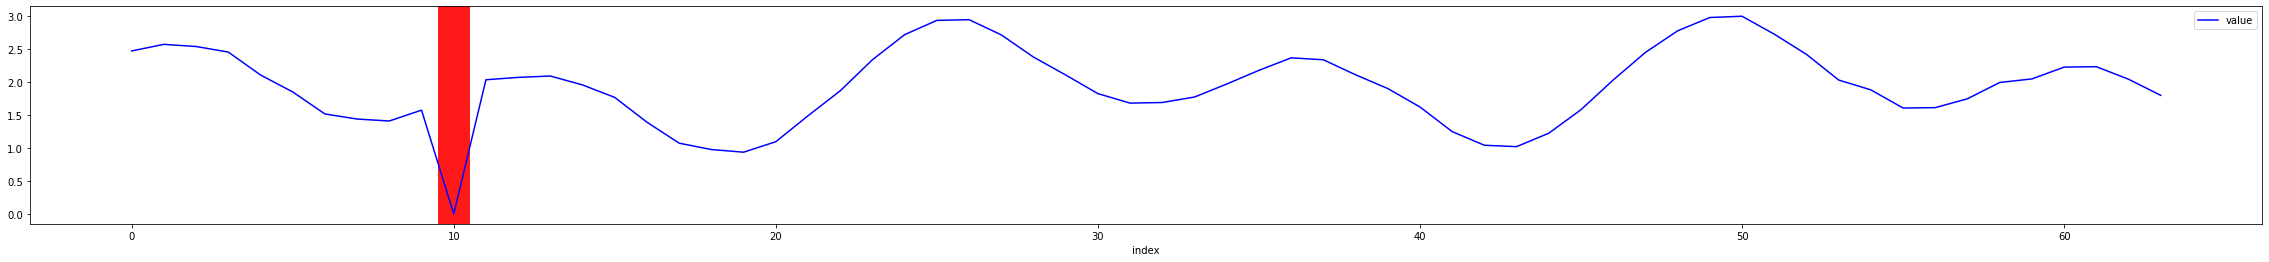

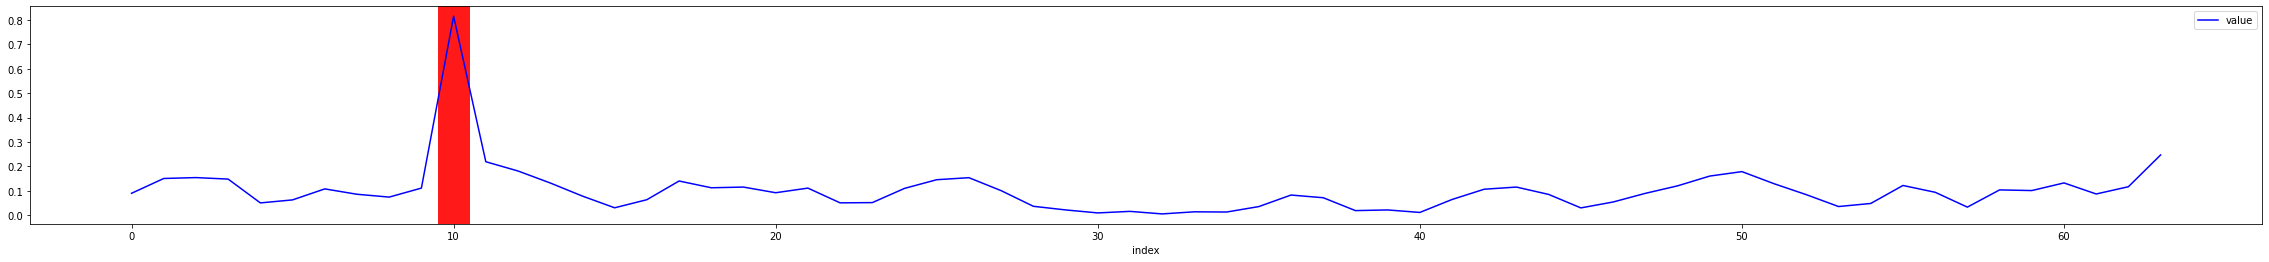

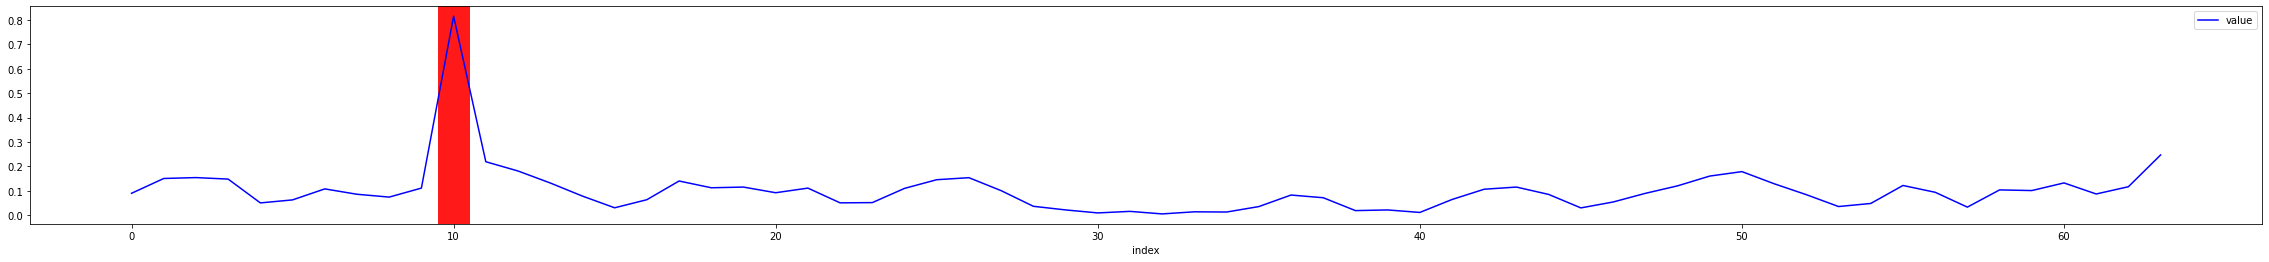

In [347]:

plots(training_data[i][0], training_data[i][1])
plots(spectral_residual(training_data[i][0]), training_data[i][1])
plots(spectral_residual(normalize(training_data[i][0])), training_data[i][1])
i+=1

In [350]:


training_dataset = SrDataset(WINDOW_SIZE, training_data, auto_label=False)
train_loader = torch.utils.data.DataLoader(dataset=training_dataset, shuffle=True,
                                               batch_size=32)
    

length : 549111


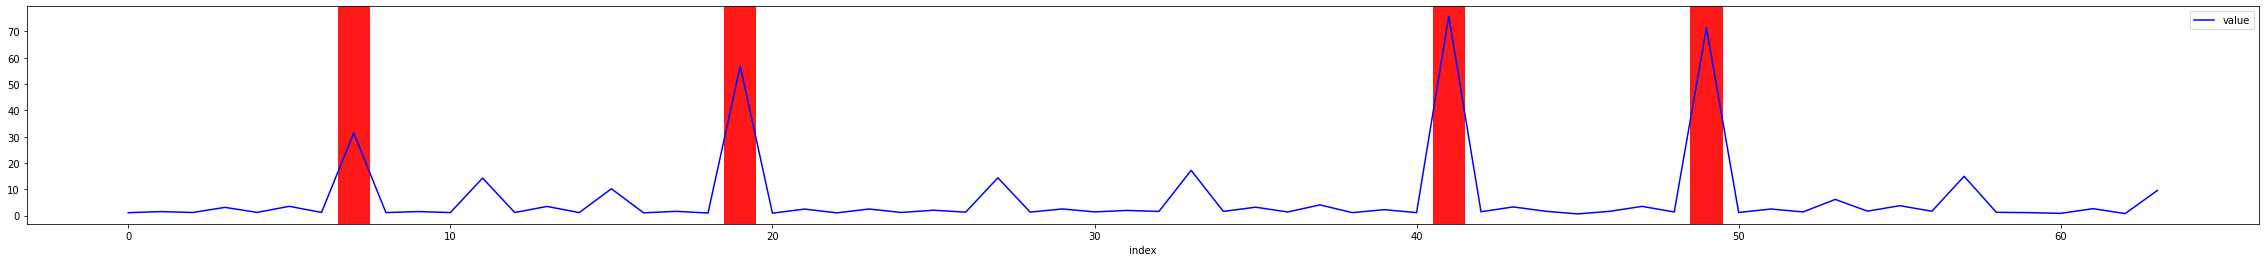

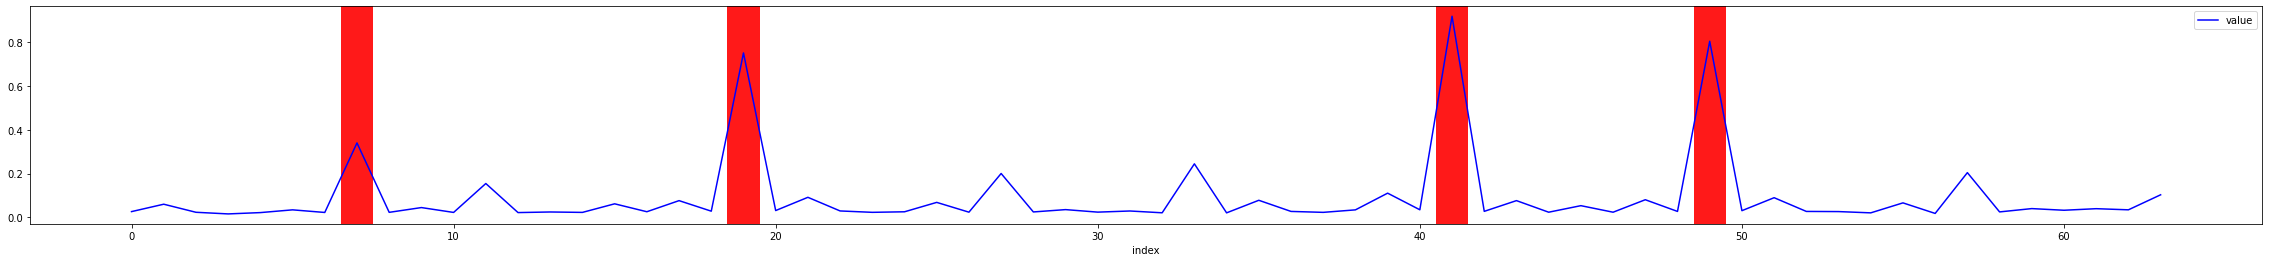

In [354]:
i=302
plots(training_dataset[i][0], training_dataset[i][1])
plots(spectral_residual(training_dataset[i][0]), training_dataset[i][1])

In [ ]:
data = np.array(training_dataset[i][1])


In [355]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data, target = data.float().to(device), target.float().to(device)

        output = model(data)
        loss = loss_function(output, target, model, 0.30) / len(data)
        loss.backward()
        optimizer.step()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        if batch_idx % 20 == 0:
            msg = "Train Epoch: {} [{}/{} ({:.0f}%)]\tloss={:.4f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item())
            print(msg)

In [376]:
device = torch.device("cpu")
model = SRCNN().to(device)

bp_parameters = filter(lambda p: p.requires_grad, model.parameters())  # back propagation parameters

optimizer = optim.SGD(bp_parameters, lr=1e-7, momentum=0.66911)

for epoch in range(1, 2):
    train(model, device, train_loader, optimizer, epoch)
    #test(args, model, device, test_loader, epoch)
    #adjust_lr(optimizer, epoch, args.lr)

Train Epoch: 1 [0/549111 (0%)]	loss=46.8099
Train Epoch: 1 [640/549111 (0%)]	loss=47.0703
Train Epoch: 1 [1280/549111 (0%)]	loss=47.1840
Train Epoch: 1 [1920/549111 (0%)]	loss=46.8207
Train Epoch: 1 [2560/549111 (0%)]	loss=46.5587
Train Epoch: 1 [3200/549111 (1%)]	loss=47.4580
Train Epoch: 1 [3840/549111 (1%)]	loss=47.4650
Train Epoch: 1 [4480/549111 (1%)]	loss=47.5523
Train Epoch: 1 [5120/549111 (1%)]	loss=46.4107
Train Epoch: 1 [5760/549111 (1%)]	loss=46.6366
Train Epoch: 1 [6400/549111 (1%)]	loss=47.1001
Train Epoch: 1 [7040/549111 (1%)]	loss=47.1145
Train Epoch: 1 [7680/549111 (1%)]	loss=45.8156
Train Epoch: 1 [8320/549111 (2%)]	loss=46.8217
Train Epoch: 1 [8960/549111 (2%)]	loss=44.9695
Train Epoch: 1 [9600/549111 (2%)]	loss=46.9457
Train Epoch: 1 [10240/549111 (2%)]	loss=44.8067
Train Epoch: 1 [10880/549111 (2%)]	loss=47.5933
Train Epoch: 1 [11520/549111 (2%)]	loss=46.4663
Train Epoch: 1 [12160/549111 (2%)]	loss=46.2779
Train Epoch: 1 [12800/549111 (2%)]	loss=47.0587
Train Epoch:

Train Epoch: 1 [108800/549111 (20%)]	loss=43.2273
Train Epoch: 1 [109440/549111 (20%)]	loss=42.5744
Train Epoch: 1 [110080/549111 (20%)]	loss=43.0925
Train Epoch: 1 [110720/549111 (20%)]	loss=42.4350
Train Epoch: 1 [111360/549111 (20%)]	loss=42.4600
Train Epoch: 1 [112000/549111 (20%)]	loss=42.3833
Train Epoch: 1 [112640/549111 (21%)]	loss=42.3158
Train Epoch: 1 [113280/549111 (21%)]	loss=43.3218
Train Epoch: 1 [113920/549111 (21%)]	loss=42.4120
Train Epoch: 1 [114560/549111 (21%)]	loss=42.6298
Train Epoch: 1 [115200/549111 (21%)]	loss=42.2073
Train Epoch: 1 [115840/549111 (21%)]	loss=42.4795
Train Epoch: 1 [116480/549111 (21%)]	loss=42.6070
Train Epoch: 1 [117120/549111 (21%)]	loss=42.2848
Train Epoch: 1 [117760/549111 (21%)]	loss=41.9503
Train Epoch: 1 [118400/549111 (22%)]	loss=41.9153
Train Epoch: 1 [119040/549111 (22%)]	loss=42.0827
Train Epoch: 1 [119680/549111 (22%)]	loss=42.1351
Train Epoch: 1 [120320/549111 (22%)]	loss=42.1929
Train Epoch: 1 [120960/549111 (22%)]	loss=40.6124


Train Epoch: 1 [213760/549111 (39%)]	loss=39.0676
Train Epoch: 1 [214400/549111 (39%)]	loss=39.2845
Train Epoch: 1 [215040/549111 (39%)]	loss=39.2015
Train Epoch: 1 [215680/549111 (39%)]	loss=38.7881
Train Epoch: 1 [216320/549111 (39%)]	loss=39.3350
Train Epoch: 1 [216960/549111 (40%)]	loss=38.8662
Train Epoch: 1 [217600/549111 (40%)]	loss=38.9908
Train Epoch: 1 [218240/549111 (40%)]	loss=38.5351
Train Epoch: 1 [218880/549111 (40%)]	loss=38.7511
Train Epoch: 1 [219520/549111 (40%)]	loss=39.0454
Train Epoch: 1 [220160/549111 (40%)]	loss=39.4263
Train Epoch: 1 [220800/549111 (40%)]	loss=38.4472
Train Epoch: 1 [221440/549111 (40%)]	loss=38.7917
Train Epoch: 1 [222080/549111 (40%)]	loss=39.0724
Train Epoch: 1 [222720/549111 (41%)]	loss=38.8266
Train Epoch: 1 [223360/549111 (41%)]	loss=38.7734
Train Epoch: 1 [224000/549111 (41%)]	loss=38.9710
Train Epoch: 1 [224640/549111 (41%)]	loss=38.7681
Train Epoch: 1 [225280/549111 (41%)]	loss=37.9598
Train Epoch: 1 [225920/549111 (41%)]	loss=38.9357


Train Epoch: 1 [318720/549111 (58%)]	loss=35.4693
Train Epoch: 1 [319360/549111 (58%)]	loss=36.0905
Train Epoch: 1 [320000/549111 (58%)]	loss=35.5693
Train Epoch: 1 [320640/549111 (58%)]	loss=35.6649
Train Epoch: 1 [321280/549111 (59%)]	loss=36.2052
Train Epoch: 1 [321920/549111 (59%)]	loss=36.1718
Train Epoch: 1 [322560/549111 (59%)]	loss=35.2260
Train Epoch: 1 [323200/549111 (59%)]	loss=35.0805
Train Epoch: 1 [323840/549111 (59%)]	loss=35.4061
Train Epoch: 1 [324480/549111 (59%)]	loss=35.5681
Train Epoch: 1 [325120/549111 (59%)]	loss=36.2477
Train Epoch: 1 [325760/549111 (59%)]	loss=35.6924
Train Epoch: 1 [326400/549111 (59%)]	loss=35.9192
Train Epoch: 1 [327040/549111 (60%)]	loss=35.8117
Train Epoch: 1 [327680/549111 (60%)]	loss=35.6637
Train Epoch: 1 [328320/549111 (60%)]	loss=36.1748
Train Epoch: 1 [328960/549111 (60%)]	loss=35.5566
Train Epoch: 1 [329600/549111 (60%)]	loss=36.4000
Train Epoch: 1 [330240/549111 (60%)]	loss=35.4426
Train Epoch: 1 [330880/549111 (60%)]	loss=35.7643


Train Epoch: 1 [423680/549111 (77%)]	loss=33.2670
Train Epoch: 1 [424320/549111 (77%)]	loss=32.6836
Train Epoch: 1 [424960/549111 (77%)]	loss=33.2397
Train Epoch: 1 [425600/549111 (78%)]	loss=32.2713
Train Epoch: 1 [426240/549111 (78%)]	loss=32.3988
Train Epoch: 1 [426880/549111 (78%)]	loss=33.4986
Train Epoch: 1 [427520/549111 (78%)]	loss=32.9989
Train Epoch: 1 [428160/549111 (78%)]	loss=32.6244
Train Epoch: 1 [428800/549111 (78%)]	loss=33.0278
Train Epoch: 1 [429440/549111 (78%)]	loss=33.2467
Train Epoch: 1 [430080/549111 (78%)]	loss=32.1788
Train Epoch: 1 [430720/549111 (78%)]	loss=32.9373
Train Epoch: 1 [431360/549111 (79%)]	loss=31.6539
Train Epoch: 1 [432000/549111 (79%)]	loss=32.7844
Train Epoch: 1 [432640/549111 (79%)]	loss=32.7036
Train Epoch: 1 [433280/549111 (79%)]	loss=32.6951
Train Epoch: 1 [433920/549111 (79%)]	loss=33.0450
Train Epoch: 1 [434560/549111 (79%)]	loss=33.0044
Train Epoch: 1 [435200/549111 (79%)]	loss=33.4229
Train Epoch: 1 [435840/549111 (79%)]	loss=32.1917


Train Epoch: 1 [528640/549111 (96%)]	loss=30.0280
Train Epoch: 1 [529280/549111 (96%)]	loss=29.5607
Train Epoch: 1 [529920/549111 (97%)]	loss=29.0517
Train Epoch: 1 [530560/549111 (97%)]	loss=31.0045
Train Epoch: 1 [531200/549111 (97%)]	loss=29.1652
Train Epoch: 1 [531840/549111 (97%)]	loss=30.1408
Train Epoch: 1 [532480/549111 (97%)]	loss=28.2647
Train Epoch: 1 [533120/549111 (97%)]	loss=29.2279
Train Epoch: 1 [533760/549111 (97%)]	loss=29.9183
Train Epoch: 1 [534400/549111 (97%)]	loss=30.4539
Train Epoch: 1 [535040/549111 (97%)]	loss=29.3289
Train Epoch: 1 [535680/549111 (98%)]	loss=30.3921
Train Epoch: 1 [536320/549111 (98%)]	loss=30.6559
Train Epoch: 1 [536960/549111 (98%)]	loss=31.3678
Train Epoch: 1 [537600/549111 (98%)]	loss=29.4057
Train Epoch: 1 [538240/549111 (98%)]	loss=29.1748
Train Epoch: 1 [538880/549111 (98%)]	loss=30.0742
Train Epoch: 1 [539520/549111 (98%)]	loss=29.0173
Train Epoch: 1 [540160/549111 (98%)]	loss=29.9519
Train Epoch: 1 [540800/549111 (98%)]	loss=29.2393


In [438]:
train(model, device, train_loader, optimizer, epoch)

Train Epoch: 1 [0/549111 (0%)]	loss=3.3505
Train Epoch: 1 [640/549111 (0%)]	loss=3.6476
Train Epoch: 1 [1280/549111 (0%)]	loss=4.6462
Train Epoch: 1 [1920/549111 (0%)]	loss=4.4897
Train Epoch: 1 [2560/549111 (0%)]	loss=3.8070
Train Epoch: 1 [3200/549111 (1%)]	loss=3.8697
Train Epoch: 1 [3840/549111 (1%)]	loss=5.0111
Train Epoch: 1 [4480/549111 (1%)]	loss=3.6900
Train Epoch: 1 [5120/549111 (1%)]	loss=5.1119
Train Epoch: 1 [5760/549111 (1%)]	loss=5.2025
Train Epoch: 1 [6400/549111 (1%)]	loss=3.9010
Train Epoch: 1 [7040/549111 (1%)]	loss=4.4152
Train Epoch: 1 [7680/549111 (1%)]	loss=3.7175
Train Epoch: 1 [8320/549111 (2%)]	loss=4.7588
Train Epoch: 1 [8960/549111 (2%)]	loss=4.4298
Train Epoch: 1 [9600/549111 (2%)]	loss=4.2002
Train Epoch: 1 [10240/549111 (2%)]	loss=4.2147
Train Epoch: 1 [10880/549111 (2%)]	loss=4.9663
Train Epoch: 1 [11520/549111 (2%)]	loss=5.3700
Train Epoch: 1 [12160/549111 (2%)]	loss=3.7657
Train Epoch: 1 [12800/549111 (2%)]	loss=3.7387
Train Epoch: 1 [13440/549111 (2%)

Train Epoch: 1 [110720/549111 (20%)]	loss=3.7021
Train Epoch: 1 [111360/549111 (20%)]	loss=3.1561
Train Epoch: 1 [112000/549111 (20%)]	loss=3.0185
Train Epoch: 1 [112640/549111 (21%)]	loss=3.6530
Train Epoch: 1 [113280/549111 (21%)]	loss=4.7695
Train Epoch: 1 [113920/549111 (21%)]	loss=3.0919
Train Epoch: 1 [114560/549111 (21%)]	loss=3.3343
Train Epoch: 1 [115200/549111 (21%)]	loss=4.7980
Train Epoch: 1 [115840/549111 (21%)]	loss=3.9483
Train Epoch: 1 [116480/549111 (21%)]	loss=4.8293
Train Epoch: 1 [117120/549111 (21%)]	loss=3.3264
Train Epoch: 1 [117760/549111 (21%)]	loss=3.6810
Train Epoch: 1 [118400/549111 (22%)]	loss=3.8064
Train Epoch: 1 [119040/549111 (22%)]	loss=4.9564
Train Epoch: 1 [119680/549111 (22%)]	loss=2.4050
Train Epoch: 1 [120320/549111 (22%)]	loss=2.9626
Train Epoch: 1 [120960/549111 (22%)]	loss=5.0238
Train Epoch: 1 [121600/549111 (22%)]	loss=3.4481
Train Epoch: 1 [122240/549111 (22%)]	loss=4.7661
Train Epoch: 1 [122880/549111 (22%)]	loss=3.4731
Train Epoch: 1 [1235

Train Epoch: 1 [218240/549111 (40%)]	loss=2.7106
Train Epoch: 1 [218880/549111 (40%)]	loss=3.0454
Train Epoch: 1 [219520/549111 (40%)]	loss=3.6931
Train Epoch: 1 [220160/549111 (40%)]	loss=3.5366
Train Epoch: 1 [220800/549111 (40%)]	loss=4.3641
Train Epoch: 1 [221440/549111 (40%)]	loss=3.5753
Train Epoch: 1 [222080/549111 (40%)]	loss=3.7795
Train Epoch: 1 [222720/549111 (41%)]	loss=4.0686
Train Epoch: 1 [223360/549111 (41%)]	loss=3.9622
Train Epoch: 1 [224000/549111 (41%)]	loss=3.2244
Train Epoch: 1 [224640/549111 (41%)]	loss=3.5932
Train Epoch: 1 [225280/549111 (41%)]	loss=4.0028
Train Epoch: 1 [225920/549111 (41%)]	loss=2.8377
Train Epoch: 1 [226560/549111 (41%)]	loss=3.8453
Train Epoch: 1 [227200/549111 (41%)]	loss=2.8723
Train Epoch: 1 [227840/549111 (41%)]	loss=3.4316
Train Epoch: 1 [228480/549111 (42%)]	loss=2.7991
Train Epoch: 1 [229120/549111 (42%)]	loss=3.3703
Train Epoch: 1 [229760/549111 (42%)]	loss=3.2148
Train Epoch: 1 [230400/549111 (42%)]	loss=3.5108
Train Epoch: 1 [2310

Train Epoch: 1 [325760/549111 (59%)]	loss=3.5047
Train Epoch: 1 [326400/549111 (59%)]	loss=4.0271
Train Epoch: 1 [327040/549111 (60%)]	loss=2.7924
Train Epoch: 1 [327680/549111 (60%)]	loss=3.0985
Train Epoch: 1 [328320/549111 (60%)]	loss=2.8244
Train Epoch: 1 [328960/549111 (60%)]	loss=3.6389
Train Epoch: 1 [329600/549111 (60%)]	loss=3.0493
Train Epoch: 1 [330240/549111 (60%)]	loss=3.4496
Train Epoch: 1 [330880/549111 (60%)]	loss=3.7140
Train Epoch: 1 [331520/549111 (60%)]	loss=4.3573
Train Epoch: 1 [332160/549111 (60%)]	loss=3.1731
Train Epoch: 1 [332800/549111 (61%)]	loss=3.8915
Train Epoch: 1 [333440/549111 (61%)]	loss=3.6135
Train Epoch: 1 [334080/549111 (61%)]	loss=3.7586
Train Epoch: 1 [334720/549111 (61%)]	loss=2.5609
Train Epoch: 1 [335360/549111 (61%)]	loss=3.2132
Train Epoch: 1 [336000/549111 (61%)]	loss=3.1301
Train Epoch: 1 [336640/549111 (61%)]	loss=3.7568
Train Epoch: 1 [337280/549111 (61%)]	loss=3.6930
Train Epoch: 1 [337920/549111 (62%)]	loss=2.4341
Train Epoch: 1 [3385

Train Epoch: 1 [433280/549111 (79%)]	loss=3.5260
Train Epoch: 1 [433920/549111 (79%)]	loss=2.8549
Train Epoch: 1 [434560/549111 (79%)]	loss=2.6481
Train Epoch: 1 [435200/549111 (79%)]	loss=3.0485
Train Epoch: 1 [435840/549111 (79%)]	loss=2.7987
Train Epoch: 1 [436480/549111 (79%)]	loss=3.7252
Train Epoch: 1 [437120/549111 (80%)]	loss=3.6208
Train Epoch: 1 [437760/549111 (80%)]	loss=2.1957
Train Epoch: 1 [438400/549111 (80%)]	loss=3.1731
Train Epoch: 1 [439040/549111 (80%)]	loss=2.8818
Train Epoch: 1 [439680/549111 (80%)]	loss=2.7664
Train Epoch: 1 [440320/549111 (80%)]	loss=3.5229
Train Epoch: 1 [440960/549111 (80%)]	loss=2.8318
Train Epoch: 1 [441600/549111 (80%)]	loss=3.2379
Train Epoch: 1 [442240/549111 (81%)]	loss=2.3334
Train Epoch: 1 [442880/549111 (81%)]	loss=3.3864
Train Epoch: 1 [443520/549111 (81%)]	loss=3.8421
Train Epoch: 1 [444160/549111 (81%)]	loss=2.6259
Train Epoch: 1 [444800/549111 (81%)]	loss=3.4278
Train Epoch: 1 [445440/549111 (81%)]	loss=2.4283
Train Epoch: 1 [4460

Train Epoch: 1 [540800/549111 (98%)]	loss=2.5686
Train Epoch: 1 [541440/549111 (99%)]	loss=2.5109
Train Epoch: 1 [542080/549111 (99%)]	loss=2.6757
Train Epoch: 1 [542720/549111 (99%)]	loss=2.5987
Train Epoch: 1 [543360/549111 (99%)]	loss=3.0698
Train Epoch: 1 [544000/549111 (99%)]	loss=2.8395
Train Epoch: 1 [544640/549111 (99%)]	loss=2.9816
Train Epoch: 1 [545280/549111 (99%)]	loss=2.7141
Train Epoch: 1 [545920/549111 (99%)]	loss=2.3228
Train Epoch: 1 [546560/549111 (100%)]	loss=2.6763
Train Epoch: 1 [547200/549111 (100%)]	loss=3.9967
Train Epoch: 1 [547840/549111 (100%)]	loss=3.0252
Train Epoch: 1 [548480/549111 (100%)]	loss=3.2058


In [360]:
torch.save(model.state_dict(), "srcnn_yahoo.pt")

In [403]:
model

SRCNN(
  (layer1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (layer2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU(inplace=True)
)

In [246]:
from prometheus_api_client import *
from prometheus_api_client import PrometheusConnect


In [248]:
prom = PrometheusConnect(url="http://127.0.0.1:9090")
prom.check_prometheus_connection()

True

In [71]:
start_time = datetime(2021, 11, 29, 0, 0, 0, 0)

end_time = datetime(2021, 12, 6, 0, 0, 0, 0)

In [72]:
metric_data = prom.custom_query_range(
    query="sum(rate(http_server_requests_seconds_count{job='product-content', outcome!='SUCCESS'}[5m])) / sum(rate(http_server_requests_seconds_count{job='product-content'}[5m]))",
    step = 60,
    start_time=start_time,
    end_time=end_time)


In [362]:
metric_df = MetricRangeDataFrame(metric_data)
metric_df = pd.DataFrame(metric_df)
metric_df.index = pd.to_datetime(metric_df.index, unit='s')
metric_df['value'] = metric_df['value'].astype('float64')

In [363]:
metric_df['value'] = metric_df['value'].fillna(0)
metric_df

,value
timestamp,
2021-11-29 00:00:00,0.000000
2021-11-29 00:01:00,0.000000
2021-11-29 00:02:00,0.000000
2021-11-29 00:03:00,0.000000
2021-11-29 00:04:00,0.000000
...,...
2021-12-05 23:56:00,0.032788
2021-12-05 23:57:00,0.032787
2021-12-05 23:58:00,0.022219


<AxesSubplot:xlabel='timestamp'>

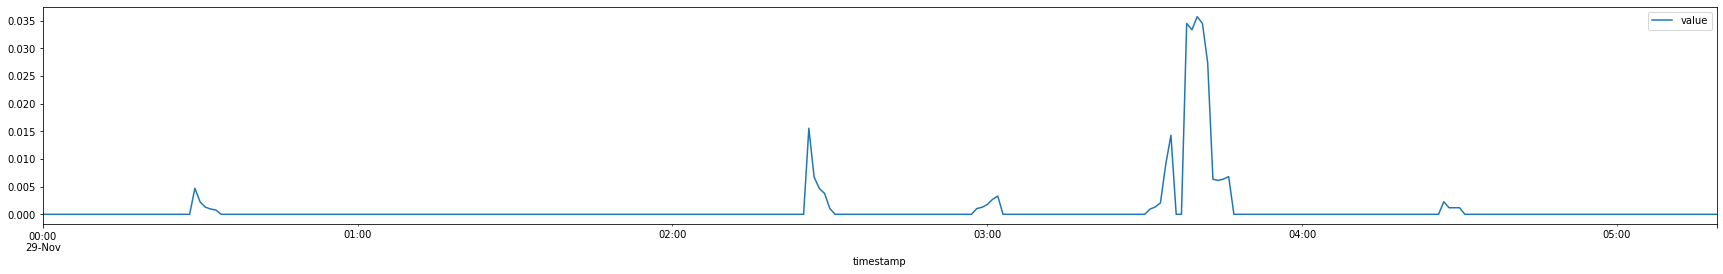

In [456]:
metric_df[0:5*WINDOW_SIZE].plot(figsize=(30,4))

In [439]:
values = metric_df[0:WINDOW_SIZE]['value'].tolist()

In [440]:
values = normalize(values)

In [441]:
values = spectral_residual(values)

In [442]:
arr = torch.FloatTensor(values).reshape(1, -1)

In [443]:
output = model(arr)
output

tensor([[0.4761, 0.4943, 0.5024, 0.4925, 0.4862, 0.4949, 0.4995, 0.4678, 0.4684,
         0.4717, 0.4903, 0.4649, 0.4912, 0.4771, 0.5035, 0.4714, 0.4850, 0.4819,
         0.4660, 0.4668, 0.4925, 0.4831, 0.4932, 0.4953, 0.4765, 0.4823, 0.4917,
         0.4624, 0.4821, 0.4736, 0.4803, 0.4746, 0.4816, 0.4870, 0.4923, 0.4710,
         0.4874, 0.4731, 0.4782, 0.4932, 0.4827, 0.4940, 0.4841, 0.4651, 0.4791,
         0.4732, 0.4927, 0.4798, 0.5065, 0.4917, 0.4964, 0.4866, 0.4833, 0.4773,
         0.4874, 0.4793, 0.4666, 0.4871, 0.4828, 0.4946, 0.4820, 0.4989, 0.4764,
         0.4740]], grad_fn=<SigmoidBackward>)

In [444]:
output[output < 0.5] = 0

In [445]:
output[output >= 0.5] = 1

In [446]:
output[output == 1]

tensor([1., 1., 1.], grad_fn=<IndexBackward>)

In [447]:
output = output.tolist()

In [448]:
output = output[0]

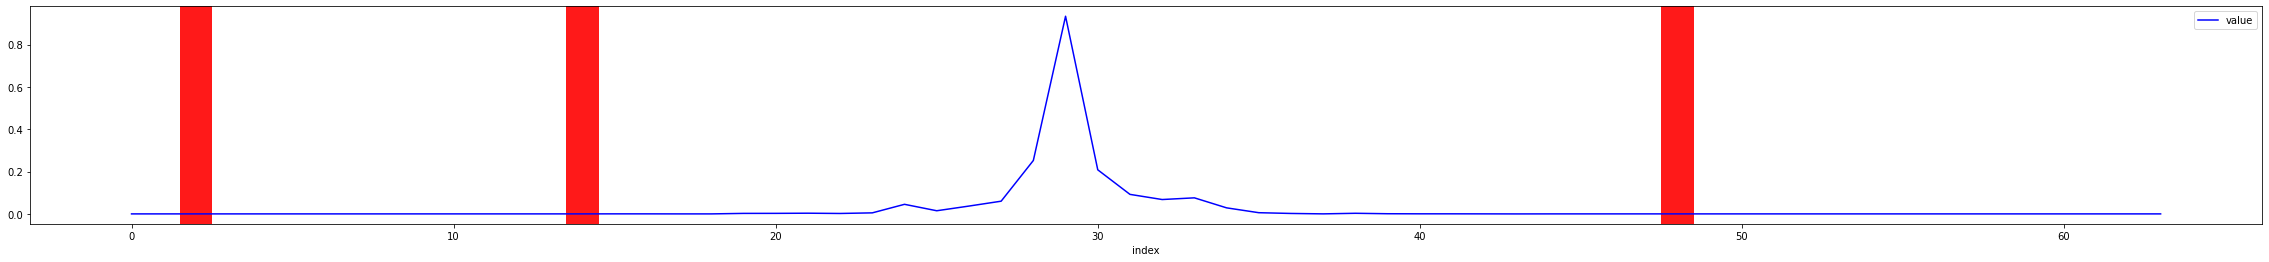

In [449]:
plots(values, output)

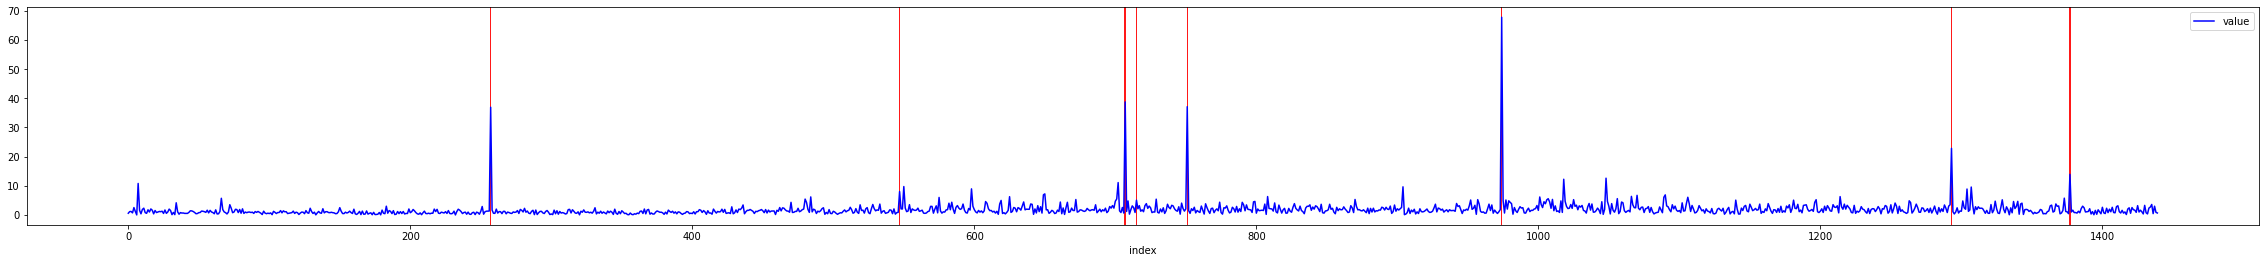

In [125]:
import pandas as pd
i=0
plots(training_dataset[i][0], training_dataset[i][1])

In [132]:
input = torch.FloatTensor(np.array(training_dataset[i][0])).reshape((1, -1))

In [141]:
output = model(input)
output

tensor([[9.9208e-05, 3.1590e-04, 5.8917e-04,  ..., 3.5053e-04, 7.0550e-03,
         7.7890e-04]], grad_fn=<SigmoidBackward>)

In [145]:
output[output >= 0.5] = 1

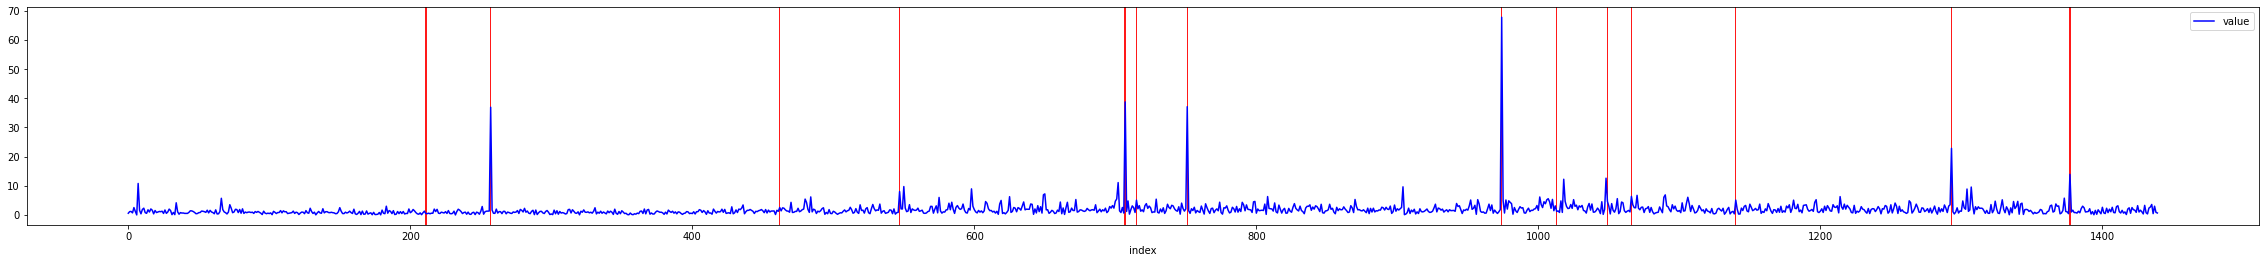

In [146]:
plots(training_dataset[i][0], output.detach().numpy()[0])